In [1]:
### Keep a record - the time taken to run this script
import time
start_time = time.time()

#### Import Libraries

In [2]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy.stats as stats
import shap

import warnings
warnings.filterwarnings('ignore')


c:\Users\elias\Anaconda3\envs\mb-ds-project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load data

In [3]:
def load_data(file):
    # generic data processing function
    df = pd.read_csv(file)
    return df

df = df = load_data('./data/Toronto Island Ferry Ticket Counts.csv')

## look at first few rows
print(df.head(3))


   _id            Timestamp  Redemption Count  Sales Count
0    1  2025-06-06T18:45:00                83            0
1    2  2025-06-06T18:30:00                82            0
2    3  2025-06-06T18:15:00                88          103


#### Explore data types, misisng values 

In [4]:
print("Check data types")
print("="*50)
print(df.info())

## We see that Timestamp is in string format, we need to convert it to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%dT%H:%M:%S')

# drop the _id column
df.drop(columns=['_id'], inplace=True)
# set the Timestamp as index
df.set_index('Timestamp', inplace=True)
# Resample to daily frequency
df_daily = df.resample('D').sum()

Check data types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246425 entries, 0 to 246424
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   _id               246425 non-null  int64 
 1   Timestamp         246425 non-null  object
 2   Redemption Count  246425 non-null  int64 
 3   Sales Count       246425 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


#### Plot the dataset

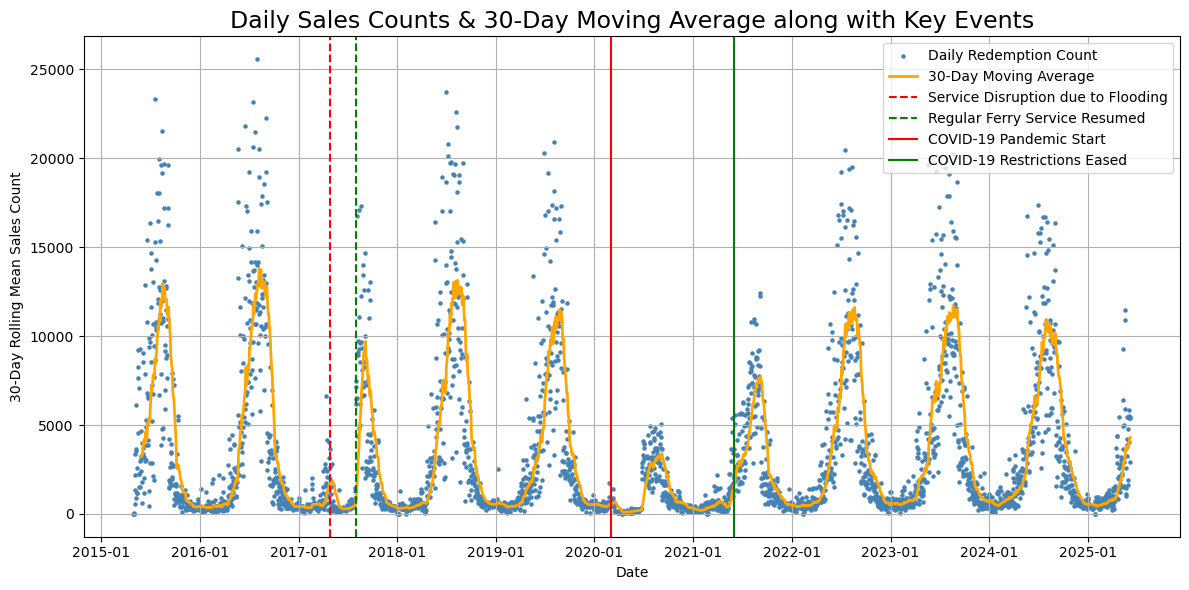

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.scatter(df_daily.index, df_daily['Sales Count'], s=5, color='steelblue', alpha=1, label='Daily Redemption Count')
ax.set_xlabel("Date")
ax.set_ylabel("Sales Count")
ax.plot(df_daily.index, df_daily['Sales Count'].shift(1).rolling(30).mean(), color='orange', alpha=1, label='30-Day Moving Average', linewidth=2)

ax.set_xlabel("Date")
ax.set_ylabel("30-Day Rolling Mean Sales Count")
# Set the x-axis major locator to year and formatter to date format
# Set x-ticks every year begin with the first date in the dataset
xticks = pd.date_range(start=df_daily.index.min(), end=df_daily.index.max(), freq='Y')
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator(1))

plt.axvline(x=pd.Timestamp('2017-04-27'), color='red', linestyle='--', label='Service Disruption due to Flooding')
plt.axvline(x=pd.Timestamp('2017-07-31'), color='green', linestyle='--', label='Regular Ferry Service Resumed')
plt.axvline(x=pd.Timestamp('2020-03-01'), color='red', linestyle='-', label='COVID-19 Pandemic Start')
plt.axvline(x=pd.Timestamp('2021-06-01'), color='green', linestyle='-', label='COVID-19 Restrictions Eased')
plt.setp(ax.get_xticklabels(), rotation=0, ha='center', fontsize=10)

plt.title("Daily Sales Counts & 30-Day Moving Average along with Key Events", fontsize=17)
plt.legend(loc='upper right', fontsize=10)
plt.grid()
plt.tight_layout()
plt.show() 


#### Observations from initial data exploration:
 
* Dataset contains 10+ years daily data (within 15 minutes interval) of "Sales Count" and "Redemption Count". The earliest date is May 1, 2015. The latest date is June 6, 2025.

* **Sales Count** is the number of tickets sold between the previous and current timestamp. This reflects customer *intention* to travel (ticket purchase).
  
* **Redemption Count** is number of tickets actually redeemed (people who boarded the ferry) between the previous and current timestamp. This reflects actual usage.
  
* There are 246,425 observations. There is **no missing values** in the dataset.
  
* We observe a **strong yearly seasonal pattern** - the rise of visitors during the Summer from May to August and valleys in the Winter.
  
* We observe two **sturctural breaks**, sudden change in the pattern or trend like a shift in level, trend, or seasonality due to an external event like flood and pandemic. In the spring of **2017**, Lake Ontario's water levels rose significantly, resulting in **severe flooding across the Toronto Islands**. In **2020**, **during the pandamic period of 2020-2021, the number of visitors dropped** due to lockdown, restrctions, and limited operations.
  
* **After the pandemic period, the number of visitors resumes to the normal seasonal pattern**.
  
* We oberve a **strong overall correlation** (0.98) between **sales count and redemption count** suggesting that the most tickets are redeemed within a close window to their purchase date  

#### Strong Correlation between Sales Count & Redemption Count

In [6]:
df_daily[["Redemption Count", "Sales Count"]].corr()

,Redemption Count,Sales Count
Redemption Count,1.000000,0.979361
Sales Count,0.979361,1.000000


#### For forecasting daily Count, post-pandemic time-series starting from 2022-01-01 has been taken.
- this dataset reflects normal behavior  in terms of trend, seasonality, and occasional spikes  

In [7]:
df2 = df_daily.copy()
df = df2[df2.index >= "2022-01-01"]

In [8]:
df.head()

,Redemption Count,Sales Count
Timestamp,,
2022-01-01,503,471
2022-01-02,345,322
2022-01-03,532,503
2022-01-04,475,412
2022-01-05,225,201


#### Plot the dataset satring from 2022-01-01 that is used for forecasting

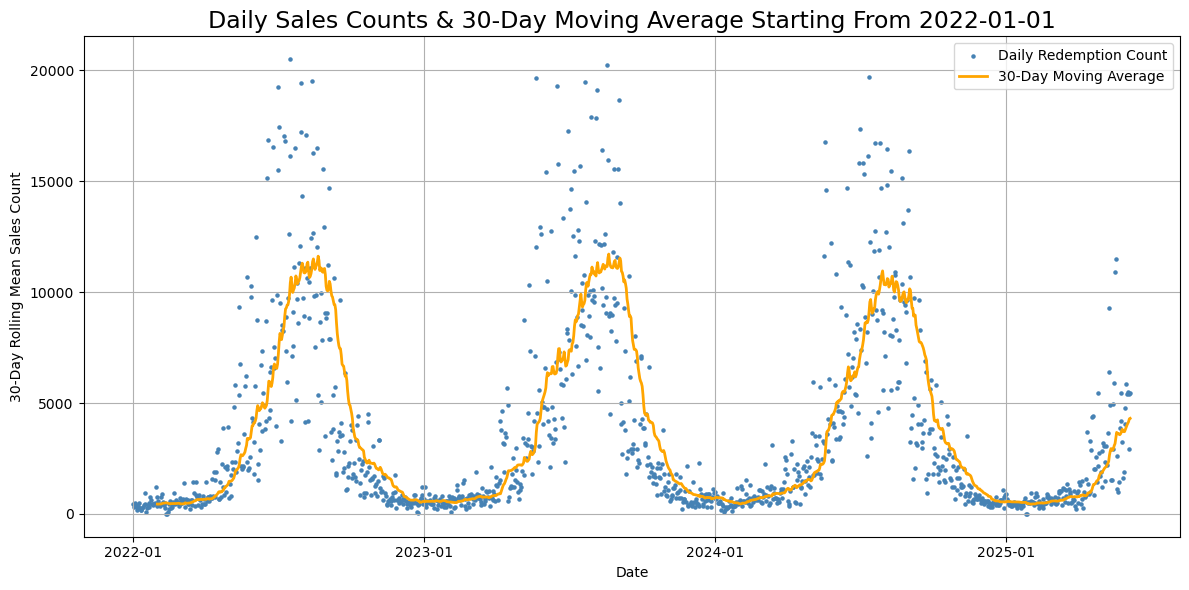

In [9]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.scatter(df.index, df['Sales Count'], s=5, color='steelblue', alpha=1, label='Daily Redemption Count')
ax.set_xlabel("Date")
ax.set_ylabel("Sales Count")
ax.plot(df.index, df['Sales Count'].shift(1).rolling(30).mean(), color='orange', alpha=1, label='30-Day Moving Average', linewidth=2)

ax.set_xlabel("Date")
ax.set_ylabel("30-Day Rolling Mean Sales Count")
# Set the x-axis major locator to year and formatter to date format
# Set x-ticks every year begin with the first date in the dataset
xticks = pd.date_range(start=df.index.min(), end=df.index.max(), freq='Y')
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator(1))


plt.title("Daily Sales Counts & 30-Day Moving Average Starting From 2022-01-01", fontsize=17)
plt.legend(loc='upper right', fontsize=10)
plt.grid()
plt.tight_layout()
plt.show() 


#### Observations:
- We observe seasonal pattern - summer hugh, winter low
- there are spikes, sudden rise of visitors
- A weekly pattern is also present, suggesting regular fluctuations aligned with weekdays and weekends.    

#### Feature Engineering 
* Capture monthly and weekly patterns in visitor behavior

* Include lag features to reflect short-term memory — for example, today is likely to behave like yesterday (lag 1), or the same weekday one or two weeks ago (lag 7, lag 14)

* Add rolling means to smooth and capture recent weekly or bi-weekly trends

* Model the weekend effect, since visitor counts are typically higher on weekends

In [10]:
target_col = "Sales Count"
# day of week: 0=Monday, 1=Tuesday,..,5=Saturday, 6=Sunday
df.loc[:, 'dayofweek'] = df.index.dayofweek # capture
# is_weekend: 1 if day of week is Saturday or Sunday, else 0
df.loc[:,'is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)
# month: 1=January, 2=February,..,12=December
df.loc[:,'month'] = df.index.month
# is_summer: 1 if month is June, July, or August, else 0
df.loc[:,"is_summer"] = df.index.month.isin([6, 7, 8]).astype(int)

# Lag features capture previous impacts on the target variable
df['lag_1'] = df[target_col].shift(1)
df['lag_7'] = df[target_col].shift(7)
df['lag_14'] = df[target_col].shift(14)
df['lag_28'] = df[target_col].shift(28)
# Rolling features capture trends over time
# Shift by 1 to avoid data leakage
# and then calculate rolling means
# Rolling means capture weekly trends over the last 1-week, 2-week, 4-week
df['rolling_7'] = df[target_col].shift(1).rolling(7).mean()
df['rolling_14'] = df[target_col].shift(1).rolling(14).mean()
# df['rolling_28'] = df[target_col].shift(1).rolling(28).mean()
# Redemption Count: We find that Sales Count is highly correlated with 
# Redemption Count, so we use it as a feature
# We've used Lag features for Sales Count, 
# because we assume that previous days' Sales Count are available
df['redemption_lag_1'] = df['Redemption Count'].shift(1)
df['redmption_lag_7'] = df['Redemption Count'].shift(7)
# Rolling means for Sales Count
# Shift by 1 to avoid data leakage
# and then calculate rolling means
df['redemption_rolling_7'] = df['Redemption Count'].shift(1).rolling(7).mean()
df['redemption_rolling_14'] = df['Redemption Count'].shift(1).rolling(14).mean()
# drop rows with NaN values having lags and rolling means
df.dropna(inplace=True)

#### Model selection
**Prophet (by Meta)** is effective for modeling trend and multiple seasonalities, and works well with irregular time series. However, it lacks the ability to capture sudden spikes or anomalies.

**XGBoost** offers a flexible, non-parametric approach. It accepts tabular input, allowing manual incorporation of features for seasonality and trend. It is generally less prone to overfitting due to built-in regularization. It is chosen as the main model due to its adaptability and performance.

**XGBoost+Residual Correction** is applied in two phases:

- Pattern Modeling: Captures weekly and bi-weekly patterns using lag features and rolling means of Redemption Count (excluding the current day's value to avoid data leakage).

- Residual Correction: Residuals from the base model were modeled separately to adjust for unexpected spikes or anomalies, producing a final corrected prediction.   

#### XGBoost hyperparameter tuning
- split the dataset
- sales count is right-skewed, so it is log-transformed

In [11]:
X = df.drop(columns=['Redemption Count', 'Sales Count'])
y = df['Sales Count']
y_log_transformed = np.log1p(y)  # Log-transform the target variable
# Hold out the last 20% as final test set (no leakage!)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_log, y_test_log = y_log_transformed.iloc[:split_idx], y_log_transformed.iloc[split_idx:]

#### Observe the right-skewed distribution of Sales Count

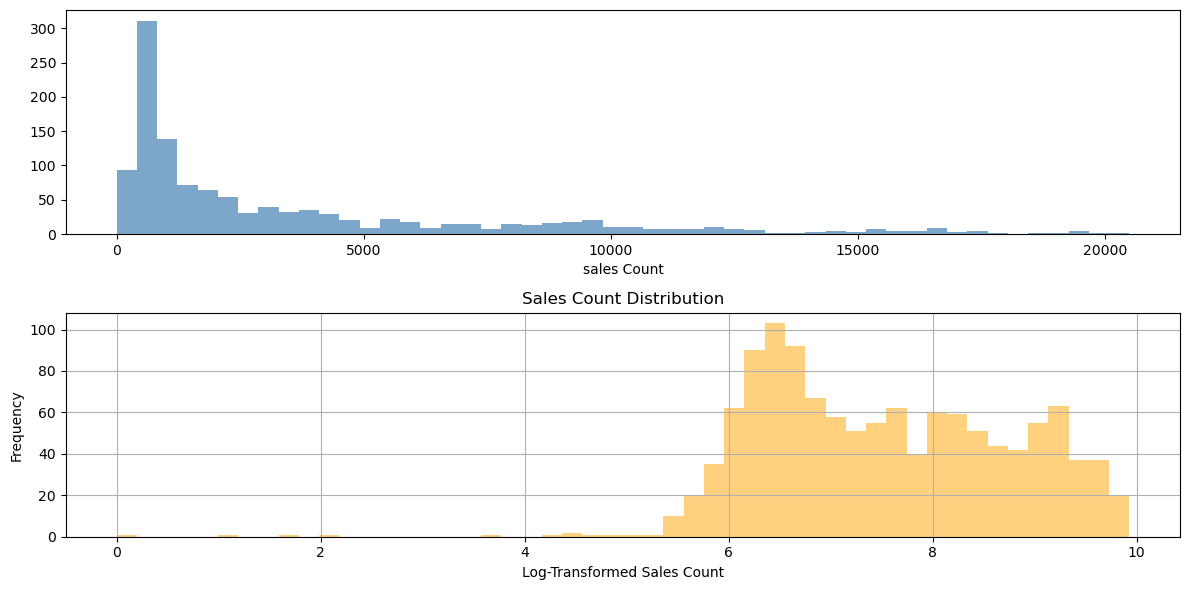

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].hist(y, bins=50, color='steelblue', alpha=0.7)
ax[1].hist(y_log_transformed, bins=50, color='orange', alpha=0.5)
#plt.title("Distribution of Log-Transformed Redemption Counts (Train Set)", fontsize=14)
ax[0].set_xlabel("sales Count")  
ax[1].set_xlabel("Log-Transformed Sales Count")      
plt.ylabel("Frequency")
plt.title("Sales Count Distribution")
plt.tight_layout()
plt.grid()  
plt.show()

In [13]:
# Check for any overlap in indices
# print(X_train.index.intersection(X_test.index))
# print(y_test_log.index.intersection(y_train_log.index))

#### Apply Cross-validation for hyper parameter tuning

In [14]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5 ],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_lambda': [0, 1, 5,10],
    'reg_alpha': [0, 1, 5,10]
}

In [15]:
tscv = TimeSeriesSplit(n_splits=3)

In [16]:
model = XGBRegressor(random_state=42)
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',  # Using MAE as the primary metric
    # scoring=smape_scorer,  # Uncomment to use SMAPE
    n_iter=20,
    verbose=1,
    n_jobs=-1
)
search.fit(X_train, y_train_log)
print("Best Score MAE:", -search.best_score_)
best_params = search.best_params_
print("Best Params:", best_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Score MAE: 0.38470071447919346
Best Params: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 10, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


#### Cross-validastion check for Model overfitting/underfitting

In [17]:
train_errors = []
test_errors = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_train)):
    # print(f"Fold {fold+1}")
    # print(f"Train indices: {train_idx[0], train_idx[-1]}, \
    #       Test indices: {test_idx[0], test_idx[-1]}")
    # Split the data into training and validation sets
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr_log, y_val_log = y_train_log.iloc[train_idx], y_train_log.iloc[test_idx]
    
    model = XGBRegressor(**best_params, random_state=42)
    model.fit(X_tr, y_tr_log)
    
    y_tr_pred_log = model.predict(X_tr)
    y_val_pred_log = model.predict(X_val)
    
   # Convert predictions back to original scale
    y_tr_pred = np.expm1(y_tr_pred_log)
    y_val_pred = np.expm1(y_val_pred_log)
    
    train_mae = mean_absolute_error(np.expm1(y_tr_log), y_tr_pred)
    test_mae = mean_absolute_error(np.expm1(y_val_log), y_val_pred)
    
    train_errors.append(train_mae)
    test_errors.append(test_mae)

    print(f"Fold {fold+1}: Train MAE = {train_mae:.2f}, Test MAE = {test_mae:.2f}")
    
# Print summary statistics only once
print(f"\nTrain MAE std. dev. : {np.std(train_errors):.2f}")
print(f"Test MAE std. dev.: {np.std(test_errors):.2f}")


Fold 1: Train MAE = 1382.61, Test MAE = 736.95
Fold 2: Train MAE = 965.79, Test MAE = 1428.78
Fold 3: Train MAE = 1022.09, Test MAE = 1537.98

Train MAE std. dev. : 184.66
Test MAE std. dev.: 354.68


##### Observations:
- There is a sign of overfitting, that xgboost learns training pattern but cannot generalize the unseen spikes (sudden increase in visitors)
- So use xgboost to learn pattern
- find the residual (= actual - pattern_preds) 
- learn the spikes, apply xgboost again for residual correction
- final model = base xgboost + residual (spike) correction  

#### define plots to check Model Performance

In [18]:
def plot_pred(results, model_name):
    '''
    Plots actual vs predicted values for each fold of a given model.
    
    Parameters:
    - results: dict containing results per model and fold
    - model_name: str, name of the model key in results (e.g., "XGBoost")
    
    For each fold:
    - Plots Actual vs Predicted values over time
    - Helps assess alignment and deviation in forecasting
    '''
    if model_name not in results:
        raise ValueError(f"No results found for model '{model_name}'")

    for cnt, result in results[model_name].items():
        truth = result.get('truth')
        preds = result.get('preds')

        if truth is not None and preds is not None:
            preds_series = pd.Series(preds, index=truth.index)

            plt.figure(figsize=(15, 6))
            plt.plot(truth.index, truth.values, label='Actual', color='grey', linewidth=2)
            plt.plot(preds_series.index, preds_series.values, label=f'{model_name} Prediction', color='red', linestyle='--')
            plt.title(f'{model_name} Forecast - Fold {cnt}', fontsize=15)
            plt.xlabel('Date')
            plt.ylabel(truth.name)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


def plot_residual_distribution_per_fold(results, model_name):
    '''
    Plots residuals for each fold separately.
    '''
    if model_name not in results:
        raise ValueError(f"No results found for model '{model_name}'")

    for cnt, result in results[model_name].items():
        
        preds = result.get('preds')
        truth = result.get('truth')

        if preds is not None and truth is not None:
            preds_series = pd.Series(preds, index=truth.index)
            res = truth - preds_series
            residuals = res.values
            dates = res.index

            fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

            sns.scatterplot(x=dates, y=residuals, color='blue', alpha=0.7, ax=ax[0])
            ax[0].axhline(0, color='red', linestyle='--')
            ax[0].set_title(f'Residuals - {model_name} - Fold {cnt}')
            ax[0].set_xlabel('Date')
            ax[0].set_ylabel('Residuals')
            ax[0].grid(True)

            sns.histplot(residuals, kde=True, ax=ax[1])
            ax[1].set_title(f'Residual Distribution - {model_name} - Fold {cnt}')
            ax[1].set_xlabel('Residuals')
            ax[1].grid(True)

            plt.tight_layout()
            plt.show()


def plot_shap_summary(results, model_name):
    '''
    Plots SHAP summary for the final fold of the specified model.
    Assumes results[model_name][fold_id] contains 'model' and 'X_test'.
    '''
    if model_name not in results:
        raise ValueError(f"Model '{model_name}' not found in results.")
    
    # Get the last fold (max cnt)
    final_fold = max(results[model_name].keys())
    result = results[model_name][final_fold]

    model = result.get('model')
    X_test = result.get('X_test')

    if model is None or X_test is None:
        raise ValueError(f"Model or X_test not stored in results['{model_name}'][{final_fold}]")

    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)

    # Summary plot
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)


#### Input parameters for forcasting `Sales Count`

In [19]:
target_col = "Sales Count"
n_splits = 4
test_size = 7 # in days

#### Fit and Run the Model 

In [20]:
# Initialize storage
results = {'XGBoost': {}, 'XGBoost+Residual': {}}

# Make a fresh copy to avoid modifying original
df_copy = df.copy()

# TimeSeries split
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

for cnt, (train_idx, test_idx) in enumerate(tscv.split(df_copy)):

    # Create folds
    X_train = df_copy.iloc[train_idx].copy()
    X_test = df_copy.iloc[test_idx].copy()

    # Target
    y_train = np.log1p(X_train[target_col])  # log1p for better distribution
    y_test = X_test[target_col]

    # Drop target from features
    X_train = X_train.drop(columns=[target_col])
    X_test = X_test.drop(columns=[target_col])

    # ==== Base Model ====
    model_pattern = XGBRegressor(**best_params, random_state=42)
    model_pattern.fit(X_train, y_train)

    preds_log = model_pattern.predict(X_test)
    base_preds = np.expm1(preds_log)  # back to original scale

    # Ensure alignment
    base_preds_series = pd.Series(base_preds, index=y_test.index)
    residuals = y_test - base_preds_series

    # Save base model results
    results['XGBoost'][cnt] = {
        'metrics': {
            'MAE': mean_absolute_error(y_test, base_preds),
            'MSE': mean_squared_error(y_test, base_preds),
            'RMSE': np.sqrt(mean_squared_error(y_test, base_preds)),
            'R2': r2_score(y_test, base_preds)
        },
        'truth': y_test,
        'preds': base_preds
    }

    # ==== Residual Model ====
    res_model = XGBRegressor(n_estimators=100, max_depth=2, learning_rate=0.05, random_state=42)
    res_model.fit(X_test, residuals)
    spike_preds = res_model.predict(X_test)

    final_preds = base_preds + spike_preds

    results['XGBoost+Residual'][cnt] = {
        'metrics': {
            'MAE': mean_absolute_error(y_test, final_preds),
            'MSE': mean_squared_error(y_test, final_preds),
            'RMSE': np.sqrt(mean_squared_error(y_test, final_preds)),
            'R2': r2_score(y_test, final_preds)
        },
        'truth': y_test,
        'preds': final_preds
    }


In [21]:
# results["XGBoost+Residual"][2]
# {'metrics': {'MAE': 33.80543736049107,
#   'MSE': 1934.3567278747048,
#   'RMSE': 43.98132248892369,
#   'R2': 0.9988930727740928},
#  'truth': Timestamp
#  2025-05-24    3890
#  2025-05-25    4200
#  2025-05-26    5468
#  2025-05-27    3260
#  2025-05-28    1637
#  2025-05-29    1890
#  2025-05-30    4786
#  Freq: D, Name: Sales Count, dtype: int64,
#  'preds': array([3878.481 , 4261.567 , 5449.8135, 3285.4607, 1626.7395, 1909.3109,
#         4695.6665], dtype=float32)}

In [22]:
# results["XGBoost"][2]=
# {'metrics': {'MAE': 477.18685477120533,
#   'MSE': 395519.8590854002,
#   'RMSE': 628.9036961931455,
#   'R2': 0.7736654805705596},
#  'truth': Timestamp
#  2025-05-24    3890
#  2025-05-25    4200
#  2025-05-26    5468
#  2025-05-27    3260
#  2025-05-28    1637
#  2025-05-29    1890
#  2025-05-30    4786
#  Freq: D, Name: Sales Count, dtype: int64,
#  'preds': array([3964.3706, 4758.207 , 4569.085 , 3618.9373, 1775.0494, 1982.388 ,
#         3566.5593], dtype=float32)}

#### Model Performance: XGBoost and XGBoost + Residual Correction

###### XGBoost

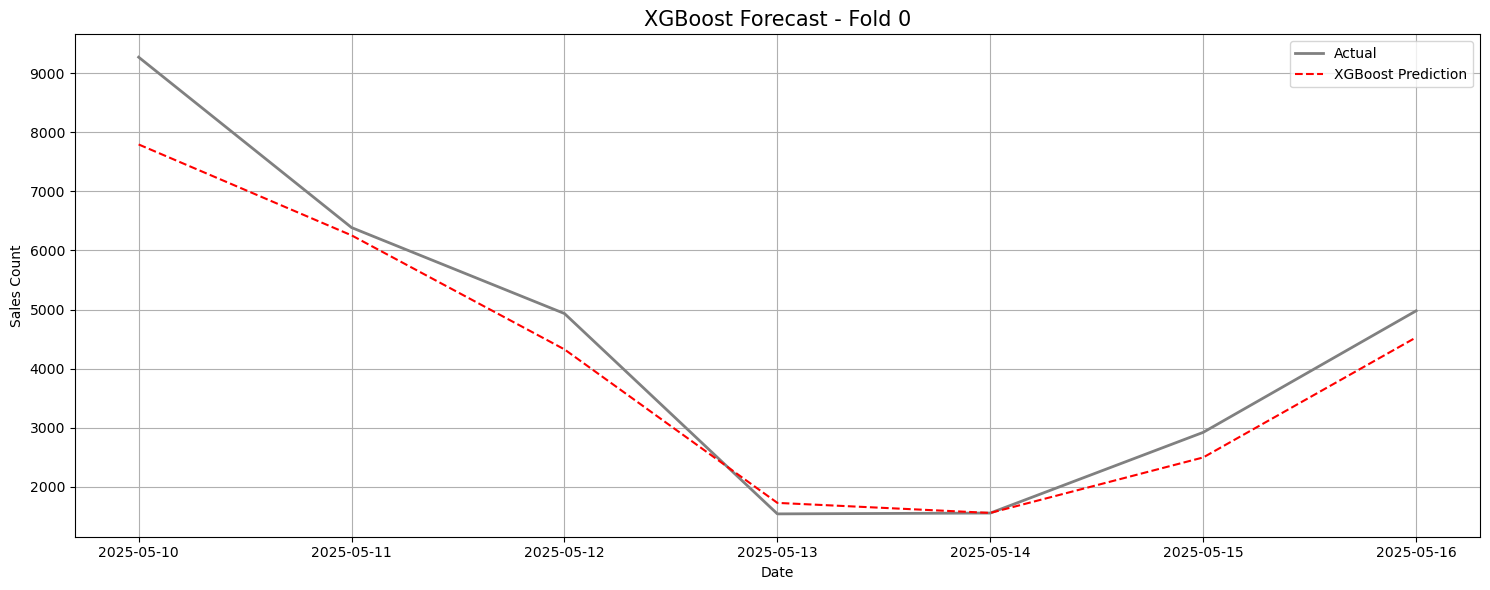

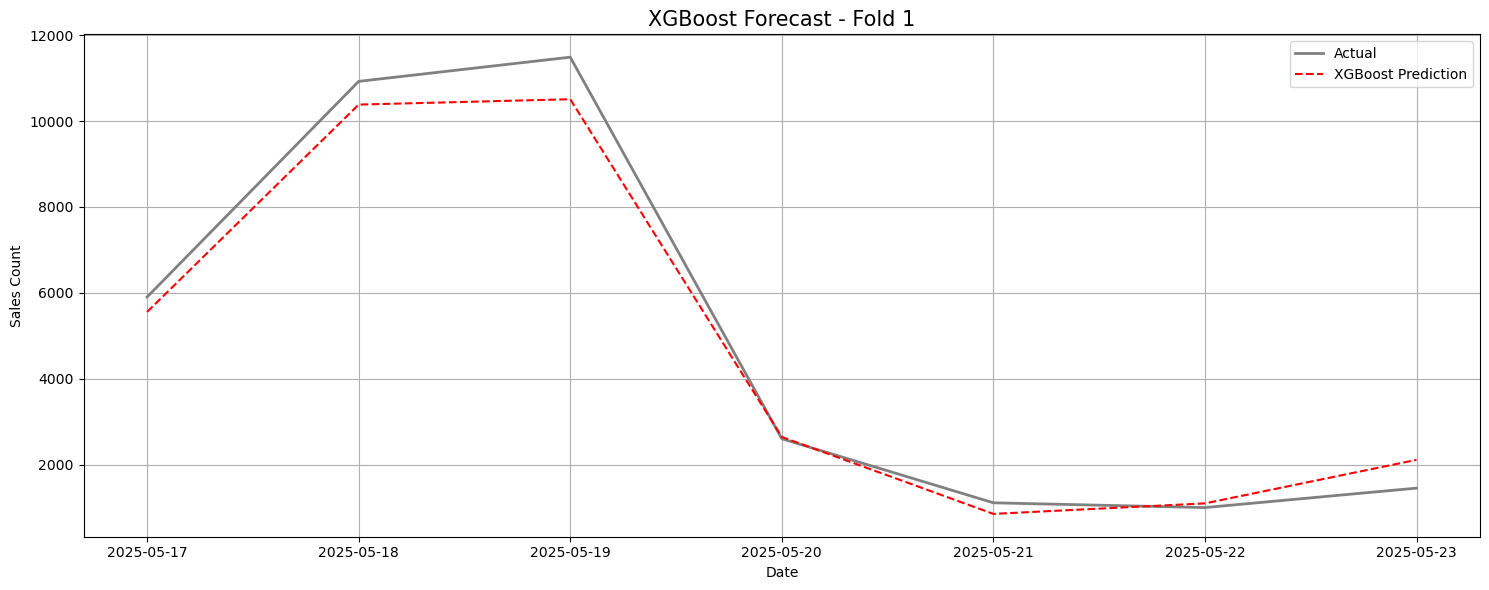

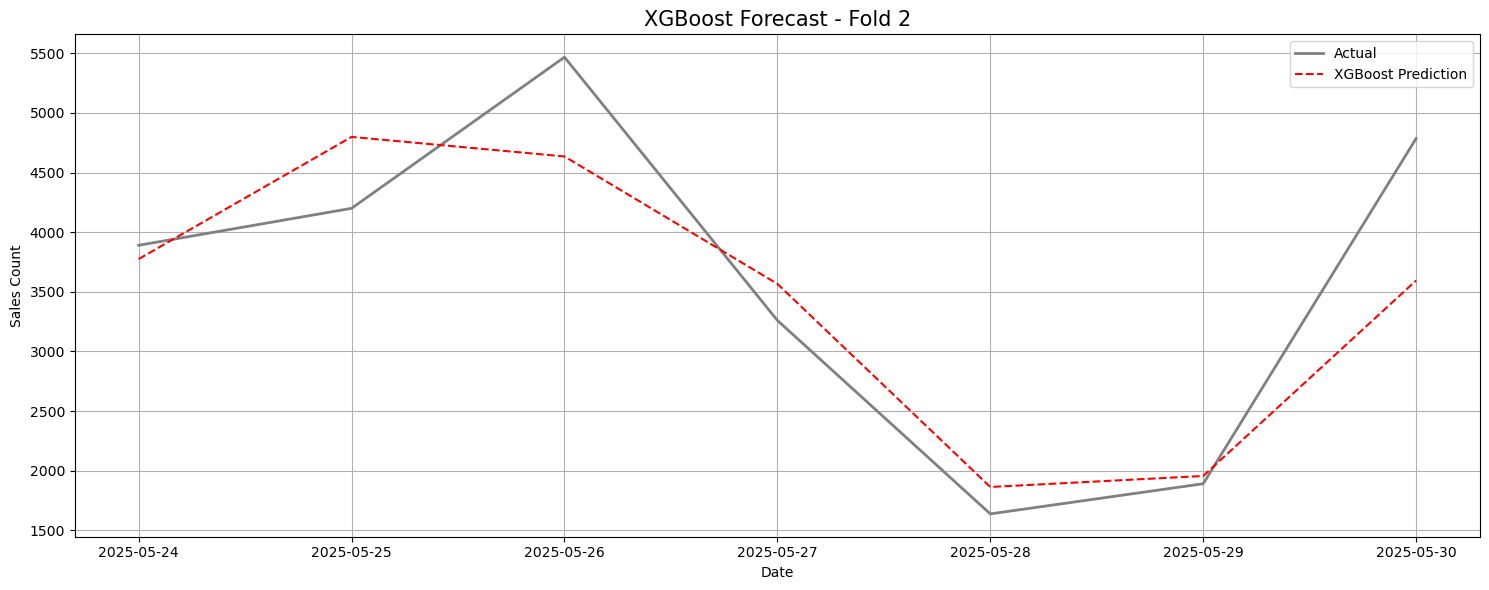

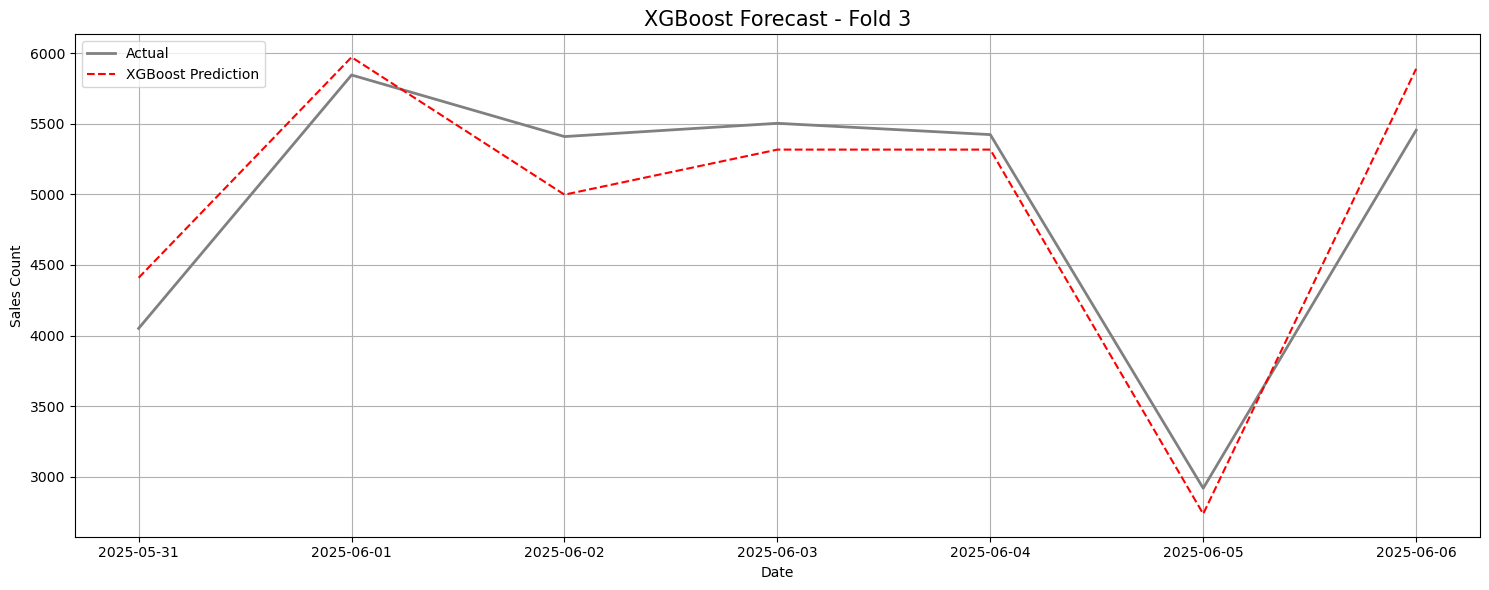

In [23]:
plot_pred(results, "XGBoost")

###### XGBoost+Residual Correction

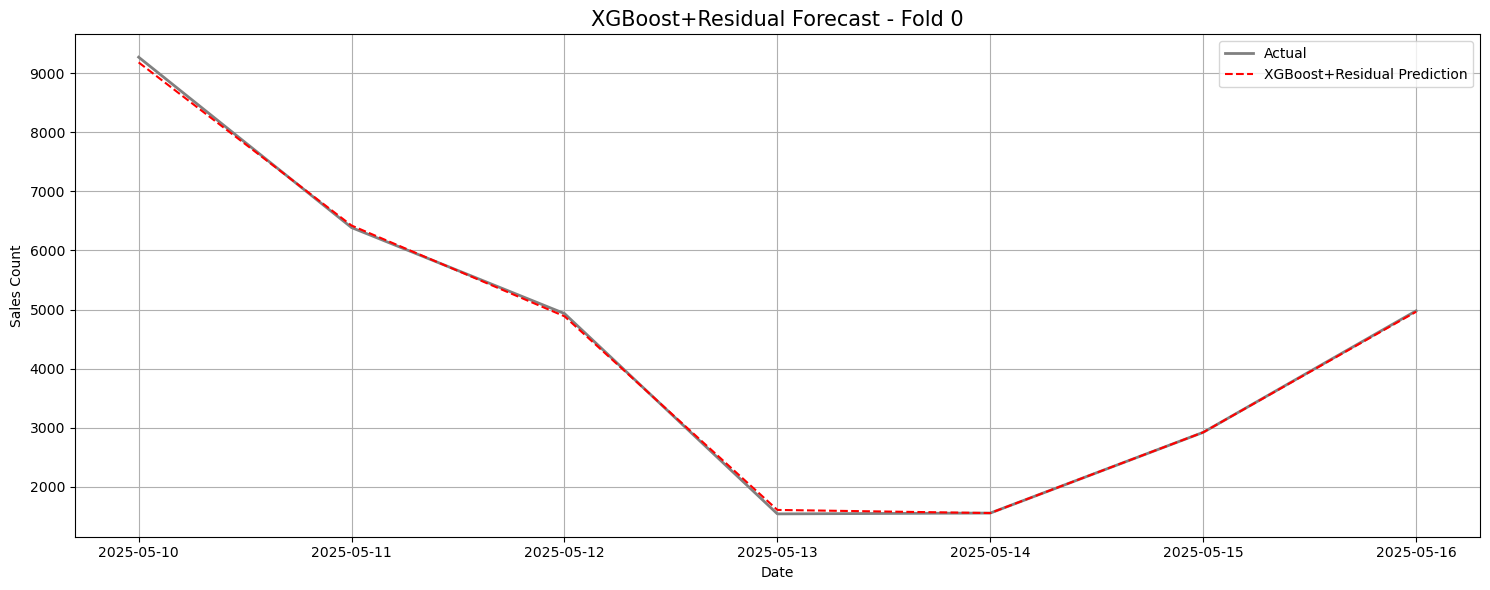

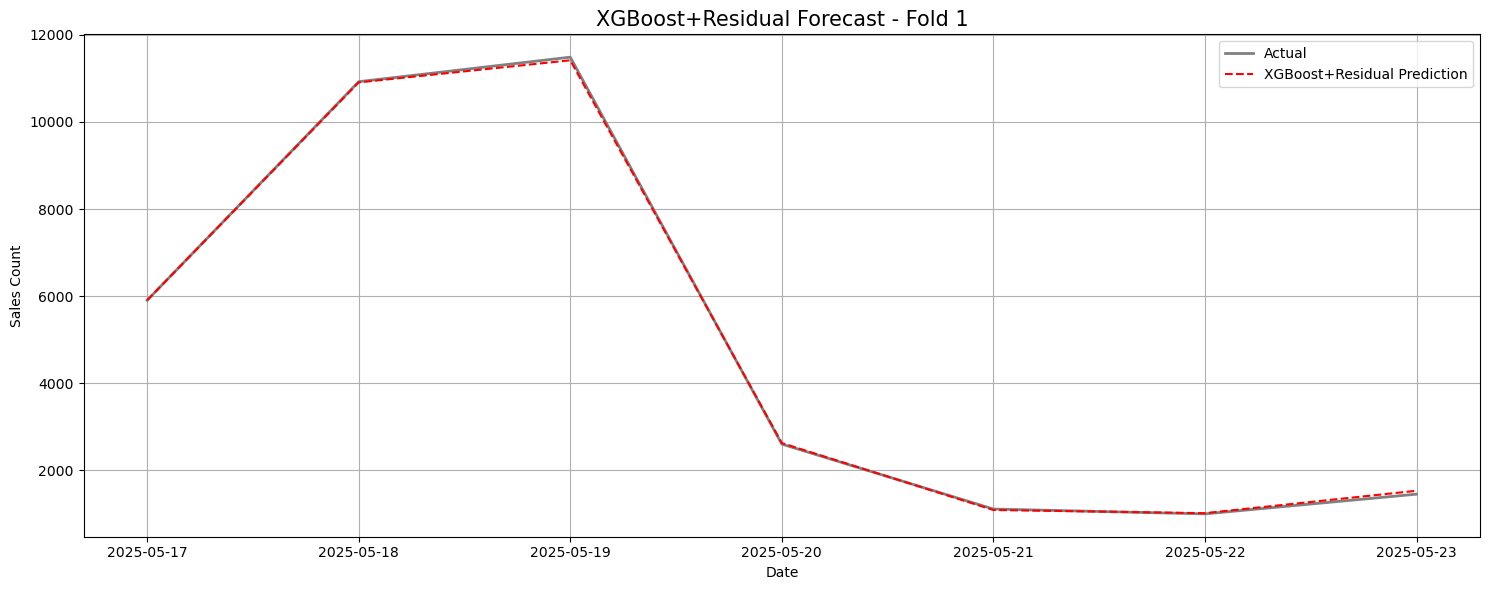

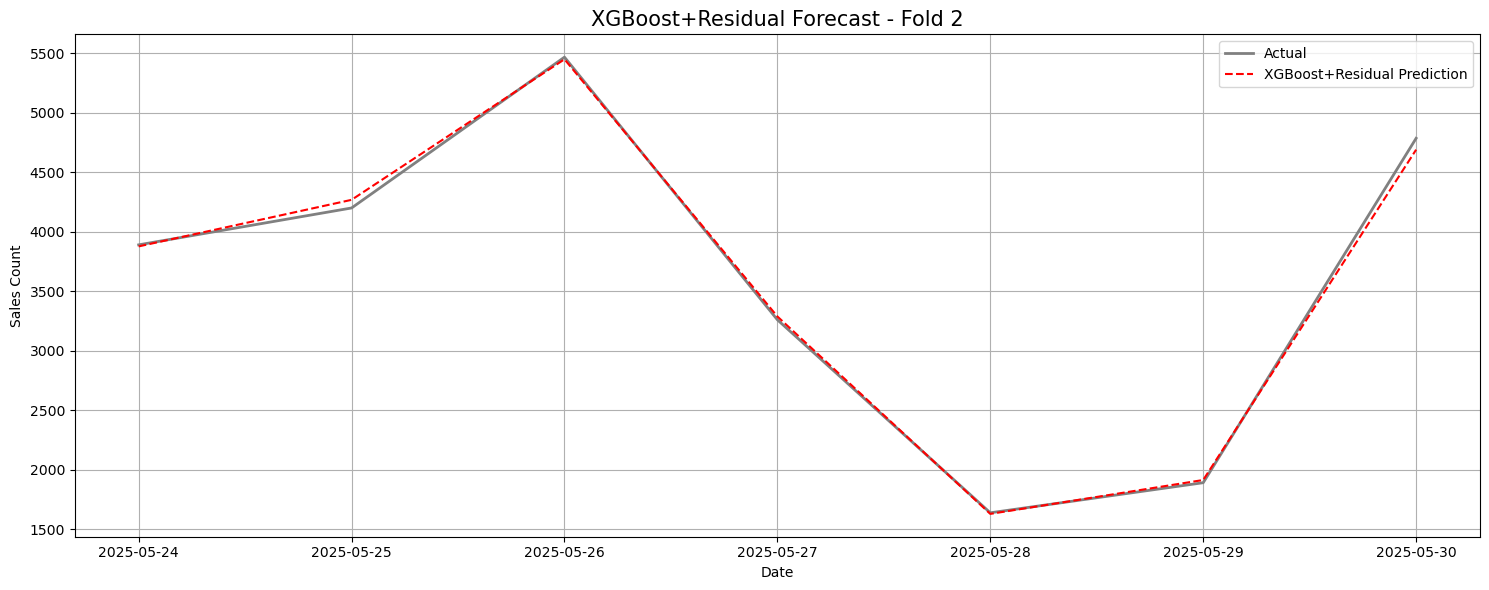

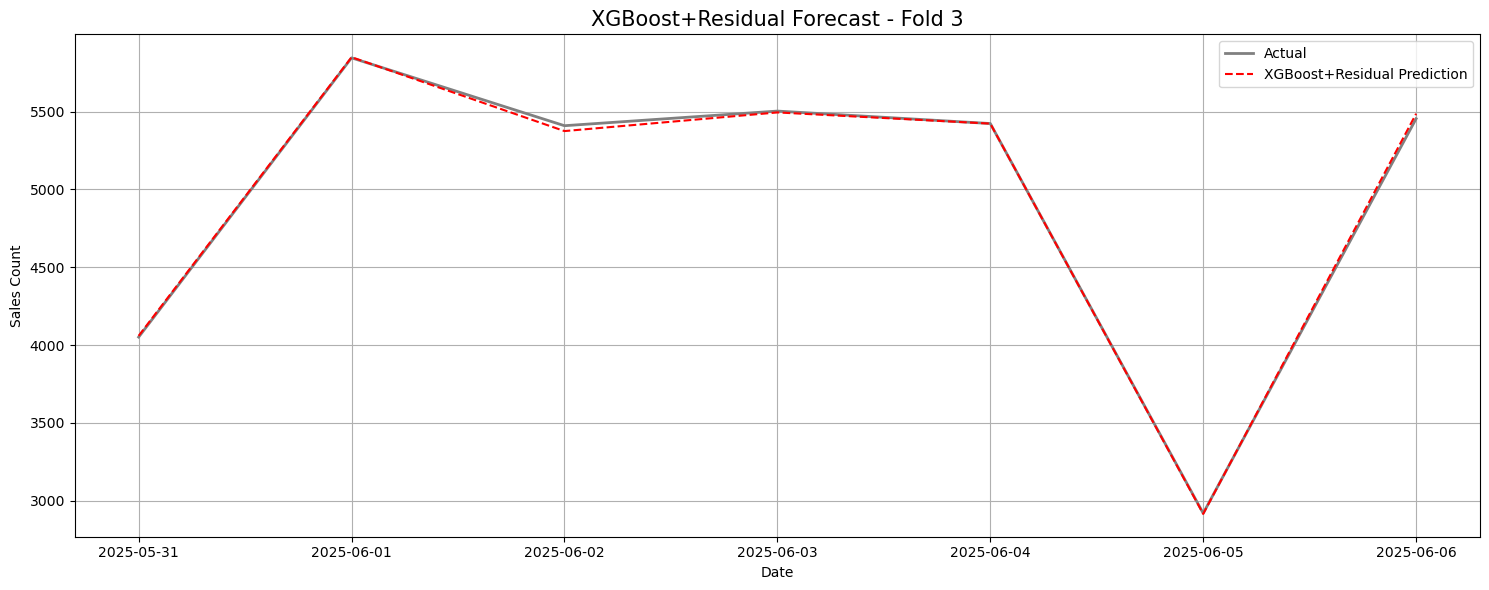

In [24]:
plot_pred(results, "XGBoost+Residual")

#### Plot Residuals: XGBoost & XGBoost+Residual Correction

##### XGBoost: Residuals over time

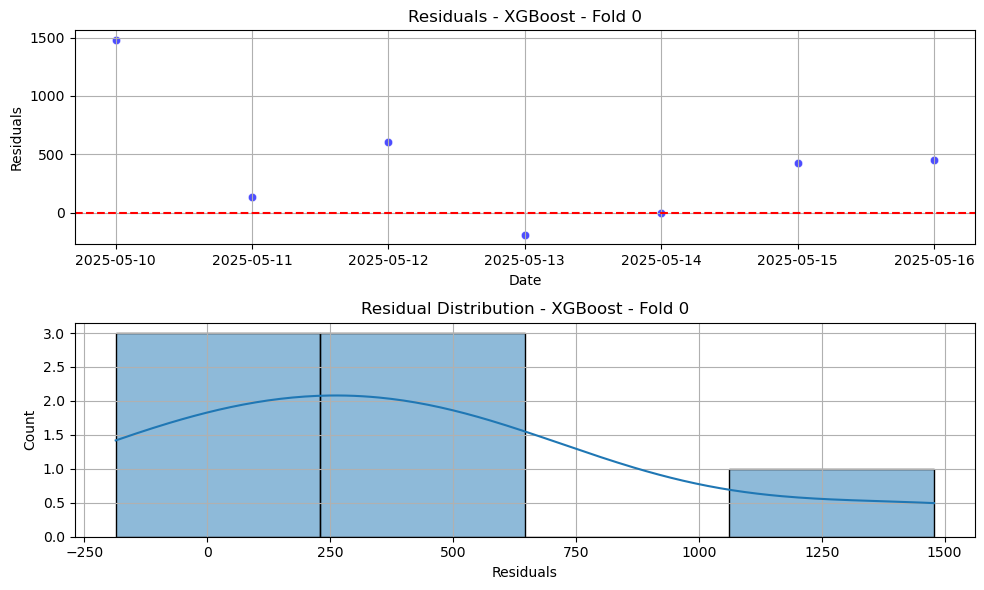

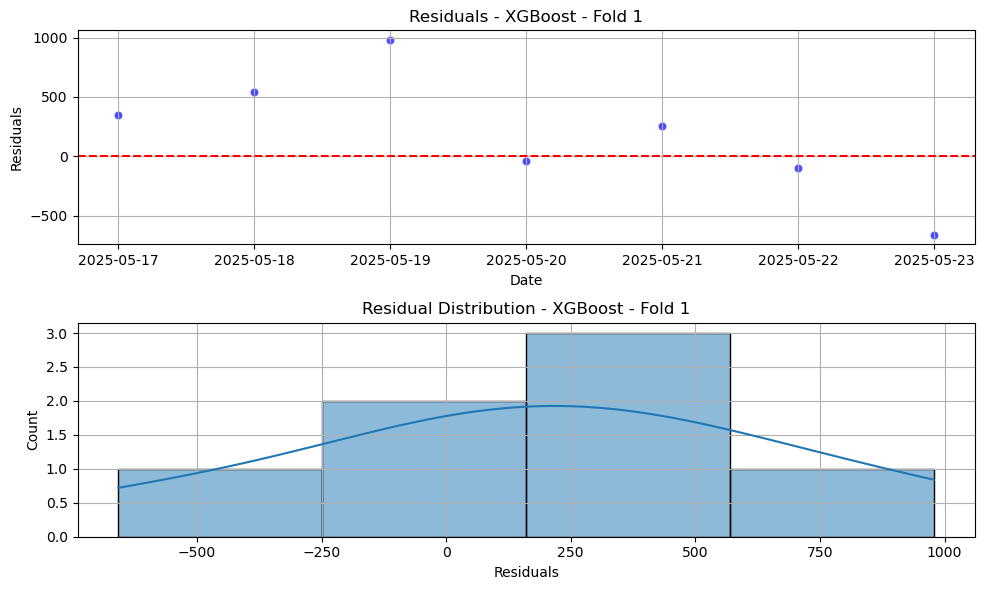

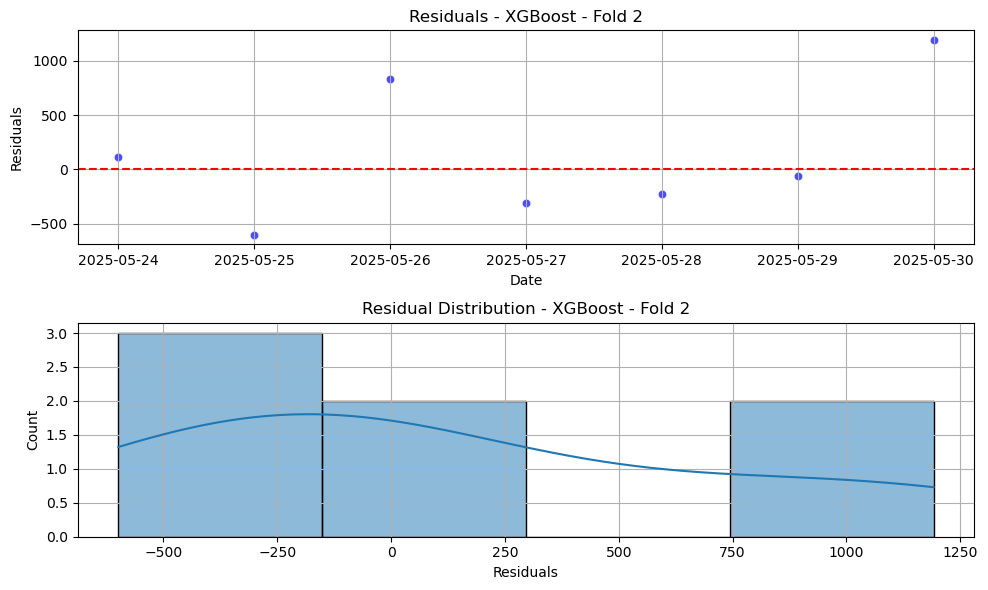

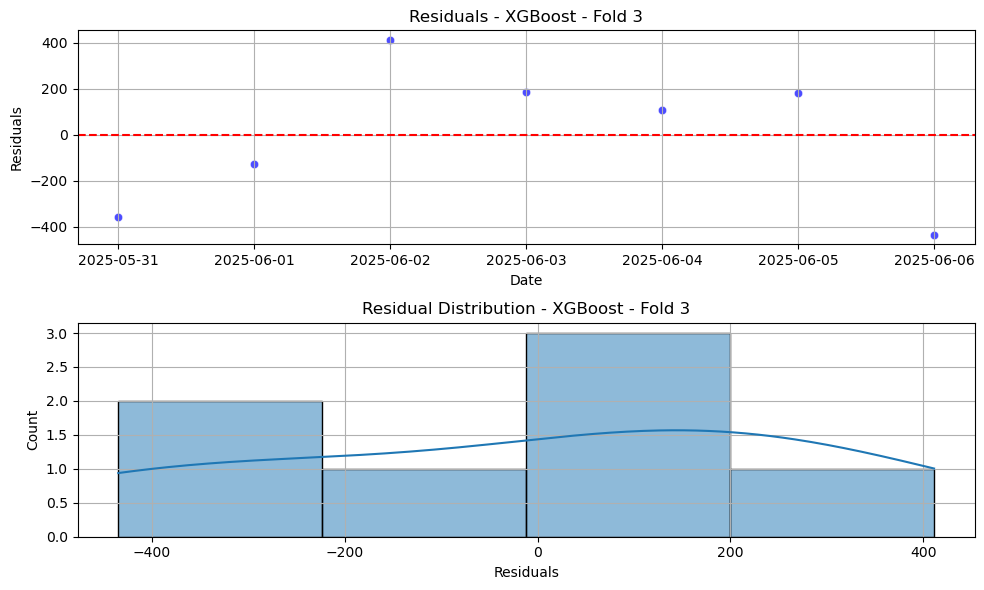

In [25]:
plot_residual_distribution_per_fold(results, "XGBoost")

##### XGBoost+Residual Correction: Residuals over time

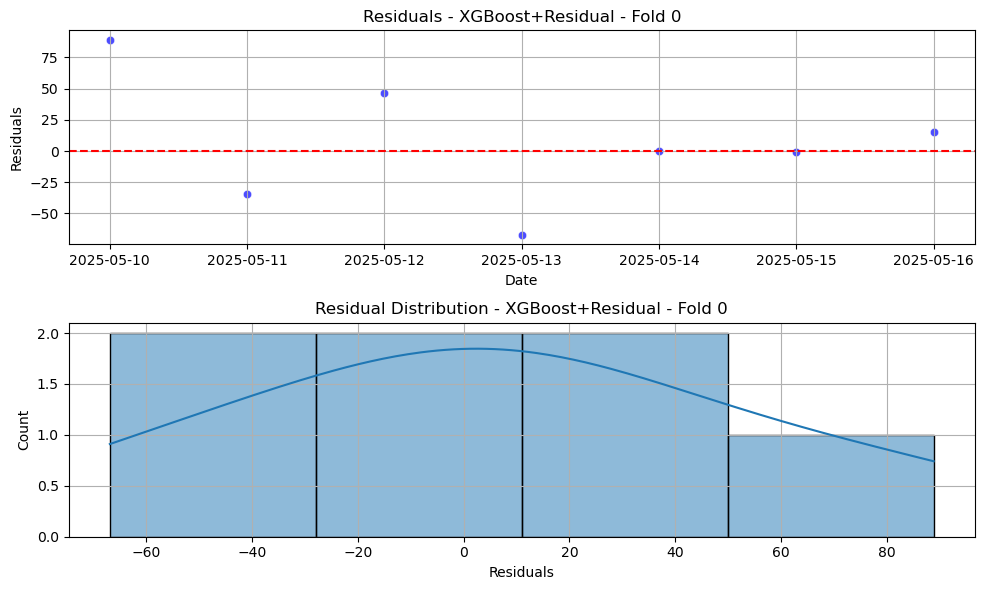

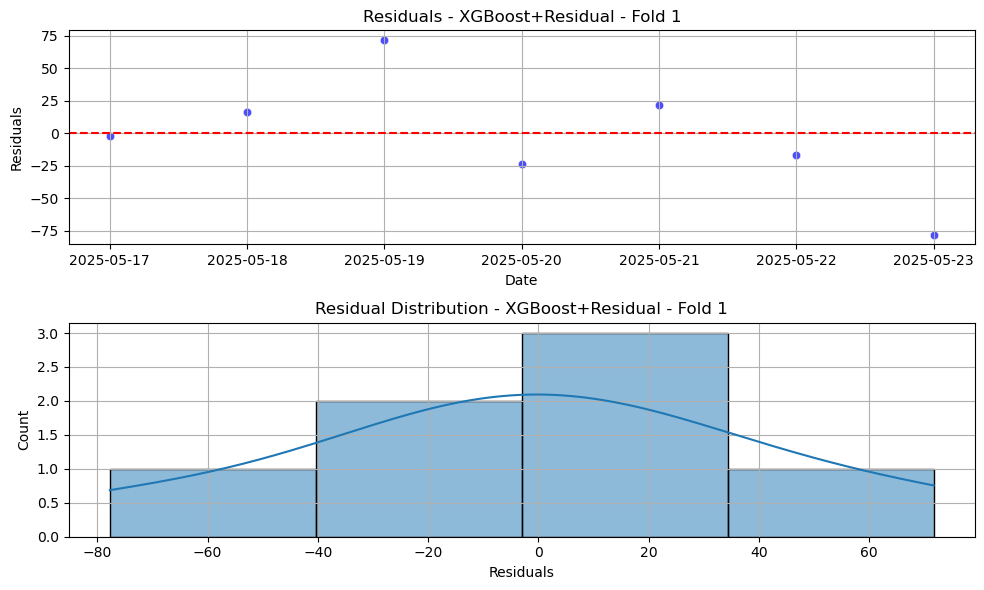

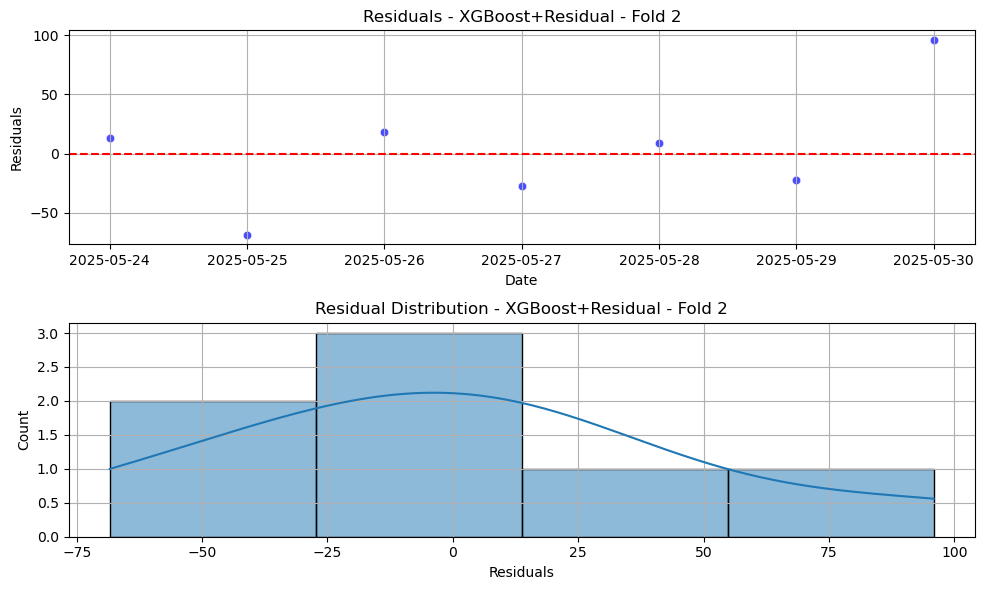

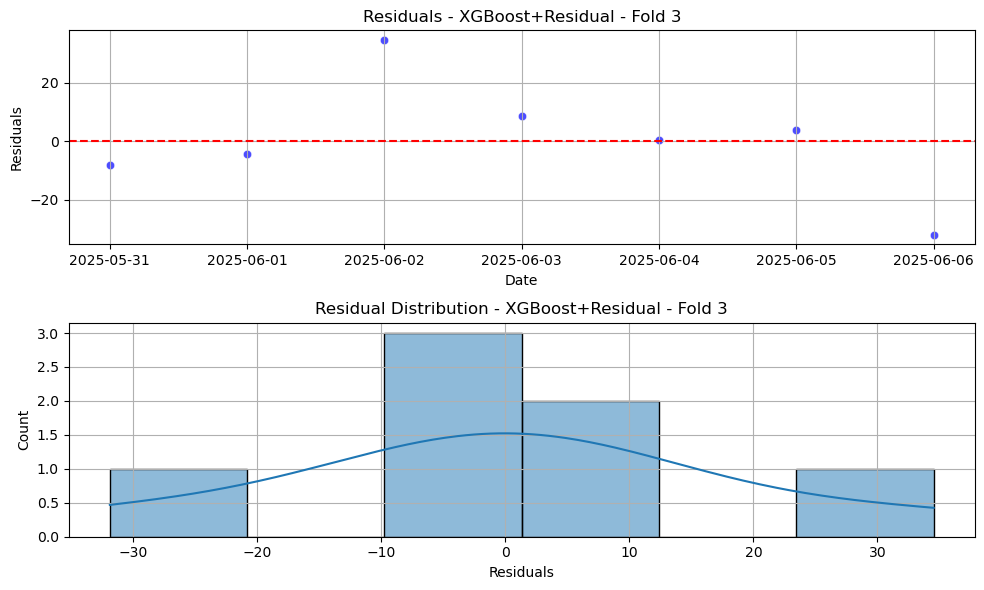

In [26]:
plot_residual_distribution_per_fold(results, "XGBoost+Residual")

In [27]:
end_time  = time.time()
print(f"Total Run time: {round(end_time - start_time, 2)} seconds")

Total Run time: 20.86 seconds


#### Conclusions

- As TimeSeriesSplit gradually increases the training size with each fold, the final fold reflects the most comprehensive model performance.

- The XGBoost + Residual Correction model consistently outperforms the base XGBoost model.

- The MAE for XGBoost is 477.18, whereas XGBoost + Residual Correction reduces it significantly to 33.80.

- The residual plot for XGBoost reveals large forecasting errors, with deviations of up to ±600.

- In contrast, the residuals for the corrected model are much tighter, varying within approximately ±40, indicating a more accurate and stable forecast.